<p><img alt="Colaboratory logo" height="240px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Logo_EAFIT.svg/2560px-Logo_EAFIT.svg.png" align="center" hspace="350px" vspace="0px"></p>

# **<center> Creación matriz de adyacencias</center>**



<center>


*Jeferson Stiven Arboleda Colorado* \\


</center>

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.2 MB/s eta 0:00:00


A continuación importamos las librerías necesarias para nuestro análisis

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import seaborn as sns
import matplotlib.pyplot as plt


Cargamos los datos tanto a nivel de barrios como de manzanas. Recordemos que usaremos aquellos asociados con la subdivisión por barrios.

In [10]:
#División por barrios
mede_bar_shp = gpd.read_file('/content/drive/MyDrive/Maestria_eafit/shapes_creados/casos_hurtos_6.shp')

#División por manzanas
mede_manz_shp = gpd.read_file('/content/drive/MyDrive/Maestria_eafit/shapes_creados/casos_hurtos_manzana_6.shp')

In [5]:
mede_bar_shp.head()

,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BAR,SECTOR,INDICADOR_,NOMBRE_COM,SHAPE__Are,SHAPE__Len,...,hoteles_ho,iglesias,tiendas_ro,centros_ma,entreten_n,centro_med,rutas_cicl,rutas_buse,cantidad_q,geometry
0,6754,1305,13,05,Metropolitano,4,U,SAN JAVIER,101866.863770,1537.700241,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,20.0,"POLYGON ((830612.612 1184766.356, 830628.022 1..."
1,6755,0701,07,01,Universidad Nacional,2,U,ROBLEDO,490437.147949,2838.152470,...,2.0,1.0,NaN,NaN,NaN,1.0,3.0,39.0,12.0,"POLYGON ((834051.745 1184956.056, 834069.208 1..."
2,6756,0510,05,10,Tricentenario,2,U,CASTILLA,421343.229492,2922.008690,...,NaN,1.0,NaN,NaN,NaN,1.0,15.0,13.0,26.0,"POLYGON ((835232.065 1188189.346, 835234.174 1..."
3,6757,1511,15,11,La Colina,6,U,GUAYABAL,689537.432617,4825.014239,...,4.0,7.0,11.0,5.0,NaN,2.0,NaN,3.0,30.0,"POLYGON ((832848.633 1177891.826, 832798.825 1..."
4,6758,1113,11,13,El Estadio,4,U,LAURELES,365142.314453,2636.136878,...,42.0,10.0,43.0,7.0,2.0,34.0,1.0,32.0,5.0,"POLYGON ((832236.017 1184432.326, 832239.859 1..."


In [6]:
mede_bar_shp.columns

Index(['OBJECTID', 'CODIGO', 'COMUNA', 'BARRIO', 'NOMBRE_BAR', 'SECTOR',
       'INDICADOR_', 'NOMBRE_COM', 'SHAPE__Are', 'SHAPE__Len', 'key', 'casos',
       'numero_ven', 'numero_sit', 'numero_sem', 'num_sedes_', 'num_postes',
       'num_parade', 'num_inst_e', 'num_hotele', 'num_esc_de', 'num_conv_n',
       'num_centro', 'num_camara', 'num_biblio', 'num_arbole', 'acopios_ta',
       'arboles_do', 'ars_camara', 'fotodetecc', 'semaforos2', 'estaciones',
       'hacienda_s', 'hacienda_c', 'hacienda_i', 'hacienda_f', 'hacienda_t',
       'paraderos_', 'centros_re', 'predios', 'farmacia', 'muebles_ti',
       'centros_po', 'gas_estaci', 'cajeros', 'centros_fi', 'entidad_ba',
       'restaurant', 'bares', 'parqueader', 'joyer_acce', 'shoe_store',
       'mall_comer', 'cafes', 'licorerias', 'tiendas_va', 'supermerca',
       'casinos', 'hoteles_ho', 'iglesias', 'tiendas_ro', 'centros_ma',
       'entreten_n', 'centro_med', 'rutas_cicl', 'rutas_buse', 'cantidad_q',
       'geometry'],
    

## **Funciones**

In [7]:
def dictNeighbors(mede_shp):
  """
  Find neighbors for a polygons geometry

  Arguments:
  ---------
  mede_shp
    Geodataframe
  
  Returns:
  -------
  Dict with polygons and its neighbors
  """
  adjt_nghbrs = {}
  for index, row in mede_shp.iterrows():
    neighbors = np.array(mede_shp[mede_shp.geometry.touches(row['geometry'])].key)
    overlap = np.array(mede_shp[mede_shp.geometry.overlaps(row['geometry'])].key)
    neighbors = np.union1d(neighbors, overlap)
    adjt_nghbrs[row.key] = list(neighbors)
  return adjt_nghbrs


In [8]:
def adjacentMatrixNeigh(dic_neigh):
  """
  Convert neighbors dict to adjacent Matrix

  Arguments:
  ---------
  dic_neigh
    Dict with polygons and its neighbors
  
  Returns:
  -------
  Adjacent matrix
  """
  adj_df = pd.DataFrame(0, index=dic_neigh.keys(), columns=dic_neigh.keys())
  for index, neighs in dic_neigh.items():
    for cols in neighs:
      adj_df.loc[index,cols] = 1
  return adj_df


In [ ]:
"""
adjt_nghbrs = {}

for index, row in mede_bar_shp.iterrows():
  print(row.key)
  #print(list(mede_bar_shp[mede_bar_shp.geometry.touches(row['geometry'])].key))
  #neighbors = list(mede_bar_shp[mede_bar_shp.geometry.touches(row['geometry'])].key)
  neighbors = np.array(mede_bar_shp[mede_bar_shp.geometry.touches(row['geometry'])].key)
  #overlapping neighbors use if discrepances found with touches
  overlap = np.array(mede_bar_shp[mede_bar_shp.geometry.overlaps(row['geometry'])].key)
  neighbors = np.union1d(neighbors, overlap)
  print(list(neighbors))
  adjt_nghbrs[row.key] = list(neighbors)
  #neighbors = neighbors.remove(row.key)
  #print(neighbors)
    #neighbors = df[df.geometry.touches(row['geometry'])].name.tolist() 
    #neighbors = neighbors.remove(row.name)
    #df.at[index, "my_neighbors"] = ", ".join(neighbors)

"""

'\nadjt_nghbrs = {}\n\nfor index, row in mede_bar_shp.iterrows():\n  print(row.key)\n  #print(list(mede_bar_shp[mede_bar_shp.geometry.touches(row[\'geometry\'])].key))\n  #neighbors = list(mede_bar_shp[mede_bar_shp.geometry.touches(row[\'geometry\'])].key)\n  neighbors = np.array(mede_bar_shp[mede_bar_shp.geometry.touches(row[\'geometry\'])].key)\n  #overlapping neighbors use if discrepances found with touches\n  overlap = np.array(mede_bar_shp[mede_bar_shp.geometry.overlaps(row[\'geometry\'])].key)\n  neighbors = np.union1d(neighbors, overlap)\n  print(list(neighbors))\n  adjt_nghbrs[row.key] = list(neighbors)\n  #neighbors = neighbors.remove(row.key)\n  #print(neighbors)\n    #neighbors = df[df.geometry.touches(row[\'geometry\'])].name.tolist() \n    #neighbors = neighbors.remove(row.name)\n    #df.at[index, "my_neighbors"] = ", ".join(neighbors)\n\n'

## **Matriz de Adyacencia a nivel de barrios**

Vamos a buscar los vecinos asociados a los diferentes barrios y con esto, se definirá las conexiones y de manera posteiror, la matriz de adyacencia.

<Axes: >

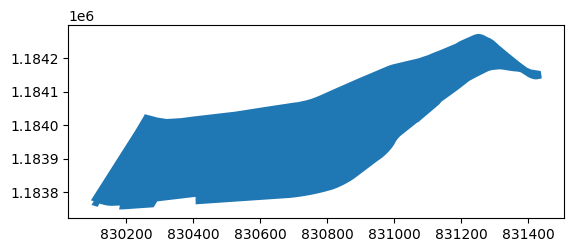

In [11]:
check = ['12_06']
mede_bar_shp[mede_bar_shp.key.isin(check)].plot()

<Axes: >

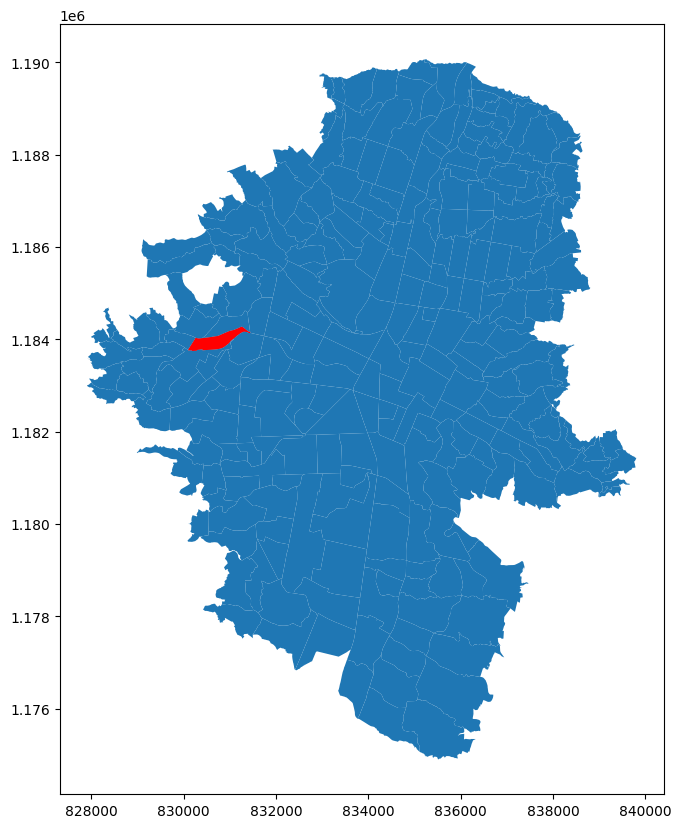

In [13]:
axis = mede_bar_shp.plot(figsize=(15,10))
mede_bar_shp[mede_bar_shp.key.isin(check)].plot(ax=axis, color = "red",markersize =0.1)

In [14]:
len(mede_bar_shp.key.unique())

265

Utilizando las funciones definidas al inicio encontramos la matriz de adyacencia.

In [15]:
#Se crea el diccionario con los vecinos
dic_neighbors = dictNeighbors(mede_bar_shp)

In [16]:
#Se crea la matriz de adyacencia
adjacent_df = adjacentMatrixNeigh(dic_neighbors)

In [17]:
adjacent_df

,13_05,07_01,05_10,15_11,11_13,03_07,05_08,14_15,03_01,08_04,...,08_13,02_10,07_08,11_08,13_14,03_11,05_07,13_07,06_02,08_05
13_05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
07_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05_10,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11_13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05_07,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
13_07,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06_02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#adjacent_df.to_csv('/content/drive/MyDrive/Maestria_eafit/adyacencia_barrios.csv')

## **Matriz de Adyacencia a nivel de manzanas en barrios:**


Realizamos un análisis similar para el caso de manzanas

In [ ]:
mede_manz_shp.head()

,OBJECTID_l,BARRIOVERE,COBAMA,SHAPE_AREA,SHAPE_LEN,nombre,index_righ,OBJECTID_r,CODIGO,COMUNA,...,iglesias,tiendas_ro,centros_ma,entreten_n,centro_med,gas_estaci,rutas_cicl,rutas_buse,cantidad_q,geometry
0,1,NaN,0102007,3981.148627,418.198377,NaN,38,6791,0102,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,"POLYGON ((837964.159 1188690.199, 837965.913 1..."
1,2,NaN,0102041,395.789943,153.853216,NaN,38,6791,0102,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,"MULTIPOLYGON (((838324.285 1188564.750, 838327..."
2,3,NaN,0102025,2166.340269,428.456959,NaN,38,6791,0102,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,"MULTIPOLYGON (((838202.585 1188541.140, 838207..."
3,8,NaN,0102027,755.183915,112.449069,NaN,38,6791,0102,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"POLYGON ((838236.516 1188557.065, 838234.647 1..."
4,23,NaN,0102017,779.242492,115.717128,NaN,38,6791,0102,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,"POLYGON ((838125.912 1188524.910, 838126.237 1..."


In [ ]:
mede_manz_shp.columns

Index(['OBJECTID_l', 'BARRIOVERE', 'COBAMA', 'SHAPE_AREA', 'SHAPE_LEN',
       'nombre', 'index_righ', 'OBJECTID_r', 'CODIGO', 'COMUNA', 'BARRIO',
       'NOMBRE_BAR', 'SECTOR', 'INDICADOR_', 'NOMBRE_COM', 'SHAPE__Are',
       'SHAPE__Len', 'indice_man', 'casos', 'numero_ven', 'numero_sit',
       'numero_sem', 'num_sedes_', 'num_postes', 'num_parade', 'num_inst_e',
       'num_hotele', 'num_esc_de', 'num_conv_n', 'num_centro', 'num_camara',
       'num_biblio', 'num_arbole', 'acopios_ta', 'arboles_do', 'ars_camara',
       'fotodetecc', 'semaforos2', 'estaciones', 'hacienda_s', 'hacienda_c',
       'hacienda_i', 'hacienda_f', 'hacienda_t', 'paraderos_', 'centros_re',
       'predios', 'farmacia', 'muebles_ti', 'centros_po', 'cajeros',
       'centros_fi', 'entidad_ba', 'restaurant', 'bares', 'parqueader',
       'joyer_acce', 'shoe_store', 'mall_comer', 'cafes', 'licorerias',
       'tiendas_va', 'supermerca', 'casinos', 'hoteles_ho', 'iglesias',
       'tiendas_ro', 'centros_ma', 'en

Creamos el índice

In [ ]:
mede_manz_shp['key'] = mede_manz_shp['COMUNA'] + '_' + mede_manz_shp['BARRIO']

Validamos su unicidad

In [ ]:
mede_manz_shp.key.unique()

array(['01_02', '01_11', '01_03', '01_05', '01_01', '01_06', '01_04',
       '01_08', '01_10', '01_12', '01_07', '01_09', '02_07', '02_01',
       '02_09', '03_01', '02_02', '02_10', '02_04', '02_03', '02_05',
       '02_11', '02_08', '02_06', '03_09', '03_05', '03_07', '03_03',
       '03_04', '03_11', '03_02', '03_08', '03_15', '03_14', '03_10',
       '03_12', '03_06', '03_13', '05_13', '05_04', '05_14', '05_11',
       '05_09', '05_07', '05_03', '05_02', '05_17', '05_01', '05_06',
       '04_07', '04_08', '04_14', '04_05', '04_15', '04_02', '04_10',
       '04_03', '04_09', '04_04', '04_12', '04_11', '05_10', '05_16',
       '04_13', '04_01', '04_16', '05_05', '05_19', '05_08', '04_06',
       '04_17', '07_10', '05_12', '08_05', '05_15', '07_09', '07_11',
       '06_03', '06_07', '06_08', '06_02', '06_05', '06_04', '06_01',
       '06_11', '06_12', '06_06', '06_09', '07_01', '06_10', '07_12',
       '07_13', '07_03', '07_04', '07_05', '07_17', '07_06', '07_07',
       '07_15', '07_

In [ ]:
mede_manz_shp.shape

(10736, 76)

In [ ]:
len(mede_manz_shp.indice_man.unique())

10736

Definimos un dataframe con valores de cero

In [ ]:
adj_mz_df = pd.DataFrame(0, index=mede_manz_shp.indice_man, columns=mede_manz_shp.indice_man)

In [ ]:
adj_mz_df

indice_man,0,1,2,3,4,5,6,7,8,9,...,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735
indice_man,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Poblamos el dataframe de acuerdo a las vecindades 

In [ ]:
for index in range(mede_manz_shp.shape[0]):
  key_val = mede_manz_shp.iloc[index].key
  same_neigh = list(mede_manz_shp[mede_manz_shp.key==key_val].indice_man)
  same_neigh.remove(index)
  for val in same_neigh:
    adj_mz_df.loc[index,val] = 1


In [ ]:
adj_mz_df

indice_man,0,1,2,3,4,5,6,7,8,9,...,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735
indice_man,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,1
10732,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,1,1
10733,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,1


In [19]:
#adj_mz_df.to_csv('/content/drive/MyDrive/Maestria_eafit/adyacencia_manz_in_barrios.csv')

## **Matriz de Adyacencia a nivel de manzanas en barrios, vecinos**

In [ ]:
def dictNeighborsMZ(mede_shp):
  adjt_nghbrs = {}
  for index, row in mede_shp.iterrows():
    neighbors = np.array(mede_shp[mede_shp.geometry.touches(row['geometry'])].indice_man)
    overlap = np.array(mede_shp[mede_shp.geometry.overlaps(row['geometry'])].indice_man)
    neighbors = np.union1d(neighbors, overlap)
    adjt_nghbrs[row.indice_man] = list(neighbors)
  return adjt_nghbrs

In [ ]:
#Se crea el diccionario con los vecinos
dic_neighbors_mz = dictNeighborsMZ(mede_manz_shp)

In [ ]:
def adjacentMatrixNeigh(dic_neigh):
  adj_df = pd.DataFrame(0, index=dic_neigh.keys(), columns=dic_neigh.keys())
  for index, neighs in dic_neigh.items():
    for cols in neighs:
      adj_df.loc[index,cols] = 1
  return adj_df

In [ ]:
adjacent_mz_df = adjacentMatrixNeigh(dic_neighbors_mz)

In [ ]:
adjacent_mz_df

,0,1,2,3,4,5,6,7,8,9,...,10726,10727,10728,10729,10730,10731,10732,10733,10734,10735
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#adjacent_mz_df.to_csv('/content/drive/MyDrive/Maestria_eafit/adyacencia_manz_neighs_barrios.csv')

## **Segregación por semans**

Hagamos a continuación el agrupamiento por semanas, el cual nos permitirá realizar nuestro análisis por ventanas temporales

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Maestria_eafit/data/hurto_completo.csv', sep='|', parse_dates=['fecha_hecho'], index_col=0)

In [ ]:
df.head()

,fecha_hecho,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,nombre_barrio,codigo_barrio,codigo_comuna,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color
0,2020-01-07 15:30:00-05:00,6.254597,-75.564769,Hombre,54,Divorciado(a),Caminata,Raponazo,Sin dato,No,Villa Nueva,#1018,10,Vía pública,Candelaria,Celular,Tecnología,Mercancía,-1,Azul
1,2020-01-07 06:30:00-05:00,6.233387,-75.544787,Mujer,36,Unión marital de hecho,Caminata,Raponazo,No,No,Los Cerros el Vergel,#0904,9,Residencia,Buenos Aires,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato
2,2020-01-07 07:50:00-05:00,6.235646,-75.563605,Mujer,35,Soltero(a),Caminata,Atraco,De celular,No,El Salvador,#0912,9,Paradero de bus,Buenos Aires,Celular,Tecnología,Mercancía,-1,Gris
3,2020-01-07 11:00:00-05:00,6.254530,-75.562335,Hombre,38,Casado(a),Automóvil,Rompimiento cerraduta,Sin dato,No,Villa Nueva,#1018,10,Taller mecánico,Candelaria,Libreta militar,Documentos,Mercancía,-1,Sin dato
4,2020-01-07 11:00:00-05:00,6.254163,-75.622267,Hombre,28,Unión marital de hecho,Caminata,Atraco,Sin dato,Arma de fuego,El Salado,#1316,13,Almacén tienda y otro,San Javier,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato


A continuación encontramos la asignación por segregación temporal de los casos

In [ ]:
df['anio'] = df.fecha_hecho.dt.year

In [ ]:
df['mes'] = df.fecha_hecho.dt.month
df['dia'] = df.fecha_hecho.dt.day
df['semana'] = df.fecha_hecho.dt.week

<ipython-input-39-27e33e016027>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['semana'] = df.fecha_hecho.dt.week


In [ ]:
df.head()

,fecha_hecho,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,...,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,anio,mes,dia,semana
0,2020-01-07 15:30:00-05:00,6.254597,-75.564769,Hombre,54,Divorciado(a),Caminata,Raponazo,Sin dato,No,...,Candelaria,Celular,Tecnología,Mercancía,-1,Azul,2020,1,7,2
1,2020-01-07 06:30:00-05:00,6.233387,-75.544787,Mujer,36,Unión marital de hecho,Caminata,Raponazo,No,No,...,Buenos Aires,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,2020,1,7,2
2,2020-01-07 07:50:00-05:00,6.235646,-75.563605,Mujer,35,Soltero(a),Caminata,Atraco,De celular,No,...,Buenos Aires,Celular,Tecnología,Mercancía,-1,Gris,2020,1,7,2
3,2020-01-07 11:00:00-05:00,6.254530,-75.562335,Hombre,38,Casado(a),Automóvil,Rompimiento cerraduta,Sin dato,No,...,Candelaria,Libreta militar,Documentos,Mercancía,-1,Sin dato,2020,1,7,2
4,2020-01-07 11:00:00-05:00,6.254163,-75.622267,Hombre,28,Unión marital de hecho,Caminata,Atraco,Sin dato,Arma de fuego,...,San Javier,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,2020,1,7,2


Filtramos aquellos registros fuera de la zona geométrica de Medellín

In [ ]:
df = df[(df['longitud'] <-75.4)&(df['longitud'] >-76)]

In [ ]:
df.shape

(181189, 24)

Utilizaremos un shape de casos, usado anteriormente

In [ ]:
mede_shp = gpd.read_file('/content/drive/MyDrive/Maestria_eafit/shapes_creados/casos_hurtos_6.shp')

<Axes: >

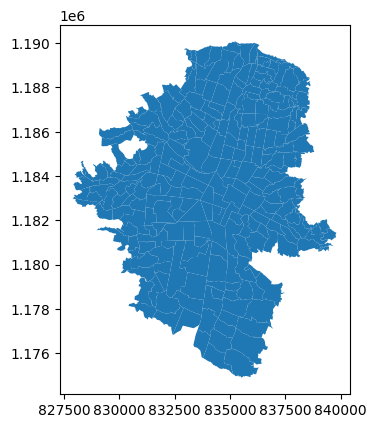

In [ ]:
mede_shp.plot()

In [ ]:
mede_shp.head()

,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BAR,SECTOR,INDICADOR_,NOMBRE_COM,SHAPE__Are,SHAPE__Len,...,hoteles_ho,iglesias,tiendas_ro,centros_ma,entreten_n,centro_med,rutas_cicl,rutas_buse,cantidad_q,geometry
0,6754,1305,13,05,Metropolitano,4,U,SAN JAVIER,101866.863770,1537.700241,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,20.0,"POLYGON ((830612.612 1184766.356, 830628.022 1..."
1,6755,0701,07,01,Universidad Nacional,2,U,ROBLEDO,490437.147949,2838.152470,...,2.0,1.0,NaN,NaN,NaN,1.0,3.0,39.0,12.0,"POLYGON ((834051.745 1184956.056, 834069.208 1..."
2,6756,0510,05,10,Tricentenario,2,U,CASTILLA,421343.229492,2922.008690,...,NaN,1.0,NaN,NaN,NaN,1.0,15.0,13.0,26.0,"POLYGON ((835232.065 1188189.346, 835234.174 1..."
3,6757,1511,15,11,La Colina,6,U,GUAYABAL,689537.432617,4825.014239,...,4.0,7.0,11.0,5.0,NaN,2.0,NaN,3.0,30.0,"POLYGON ((832848.633 1177891.826, 832798.825 1..."
4,6758,1113,11,13,El Estadio,4,U,LAURELES,365142.314453,2636.136878,...,42.0,10.0,43.0,7.0,2.0,34.0,1.0,32.0,5.0,"POLYGON ((832236.017 1184432.326, 832239.859 1..."


In [ ]:
mede_shp.shape

(265, 68)

In [ ]:
mede_shp.columns

Index(['OBJECTID', 'CODIGO', 'COMUNA', 'BARRIO', 'NOMBRE_BAR', 'SECTOR',
       'INDICADOR_', 'NOMBRE_COM', 'SHAPE__Are', 'SHAPE__Len', 'key', 'casos',
       'numero_ven', 'numero_sit', 'numero_sem', 'num_sedes_', 'num_postes',
       'num_parade', 'num_inst_e', 'num_hotele', 'num_esc_de', 'num_conv_n',
       'num_centro', 'num_camara', 'num_biblio', 'num_arbole', 'acopios_ta',
       'arboles_do', 'ars_camara', 'fotodetecc', 'semaforos2', 'estaciones',
       'hacienda_s', 'hacienda_c', 'hacienda_i', 'hacienda_f', 'hacienda_t',
       'paraderos_', 'centros_re', 'predios', 'farmacia', 'muebles_ti',
       'centros_po', 'gas_estaci', 'cajeros', 'centros_fi', 'entidad_ba',
       'restaurant', 'bares', 'parqueader', 'joyer_acce', 'shoe_store',
       'mall_comer', 'cafes', 'licorerias', 'tiendas_va', 'supermerca',
       'casinos', 'hoteles_ho', 'iglesias', 'tiendas_ro', 'centros_ma',
       'entreten_n', 'centro_med', 'rutas_cicl', 'rutas_buse', 'cantidad_q',
       'geometry'],
    

Validamos el correcto sistema de georreferencia

In [ ]:
mede_shp= mede_shp.to_crs("EPSG:4326")

Leemos como un geodataframe

In [ ]:
hurtos_coord = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitud, df.latitud), crs=4326
)

In [ ]:
hurtos_coord.head()

,fecha_hecho,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,...,bien,categoria_bien,grupo_bien,modelo,color,anio,mes,dia,semana,geometry
0,2020-01-07 15:30:00-05:00,6.254597,-75.564769,Hombre,54,Divorciado(a),Caminata,Raponazo,Sin dato,No,...,Celular,Tecnología,Mercancía,-1,Azul,2020,1,7,2,POINT (-75.56477 6.25460)
1,2020-01-07 06:30:00-05:00,6.233387,-75.544787,Mujer,36,Unión marital de hecho,Caminata,Raponazo,No,No,...,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,2020,1,7,2,POINT (-75.54479 6.23339)
2,2020-01-07 07:50:00-05:00,6.235646,-75.563605,Mujer,35,Soltero(a),Caminata,Atraco,De celular,No,...,Celular,Tecnología,Mercancía,-1,Gris,2020,1,7,2,POINT (-75.56361 6.23565)
3,2020-01-07 11:00:00-05:00,6.254530,-75.562335,Hombre,38,Casado(a),Automóvil,Rompimiento cerraduta,Sin dato,No,...,Libreta militar,Documentos,Mercancía,-1,Sin dato,2020,1,7,2,POINT (-75.56234 6.25453)
4,2020-01-07 11:00:00-05:00,6.254163,-75.622267,Hombre,28,Unión marital de hecho,Caminata,Atraco,Sin dato,Arma de fuego,...,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,2020,1,7,2,POINT (-75.62227 6.25416)


In [ ]:
hurtos_coord.shape

(181189, 25)

In [ ]:
mede_shp = mede_shp[['OBJECTID', 'CODIGO', 'COMUNA', 'BARRIO', 'NOMBRE_BAR', 'SECTOR',
       'INDICADOR_', 'NOMBRE_COM', 'SHAPE__Are', 'SHAPE__Len', 'key', 'geometry']]

In [ ]:
hurtos_coord.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 181189 entries, 0 to 181203
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype                                 
---  ------             --------------   -----                                 
 0   fecha_hecho        181189 non-null  datetime64[ns, pytz.FixedOffset(-300)]
 1   latitud            181189 non-null  float64                               
 2   longitud           181189 non-null  float64                               
 3   sexo               181189 non-null  object                                
 4   edad               181189 non-null  int64                                 
 5   estado_civil       181189 non-null  object                                
 6   medio_transporte   181189 non-null  object                                
 7   modalidad          181189 non-null  object                                
 8   conducta_especial  181189 non-null  object                                
 

Vemos de nuevo que tenemos casos de hurtos por fuera de los límites de nuestro análisis, por lo que es necesario realizar un join espacial que permita solo quedarnos con los que nos competen

<Axes: >

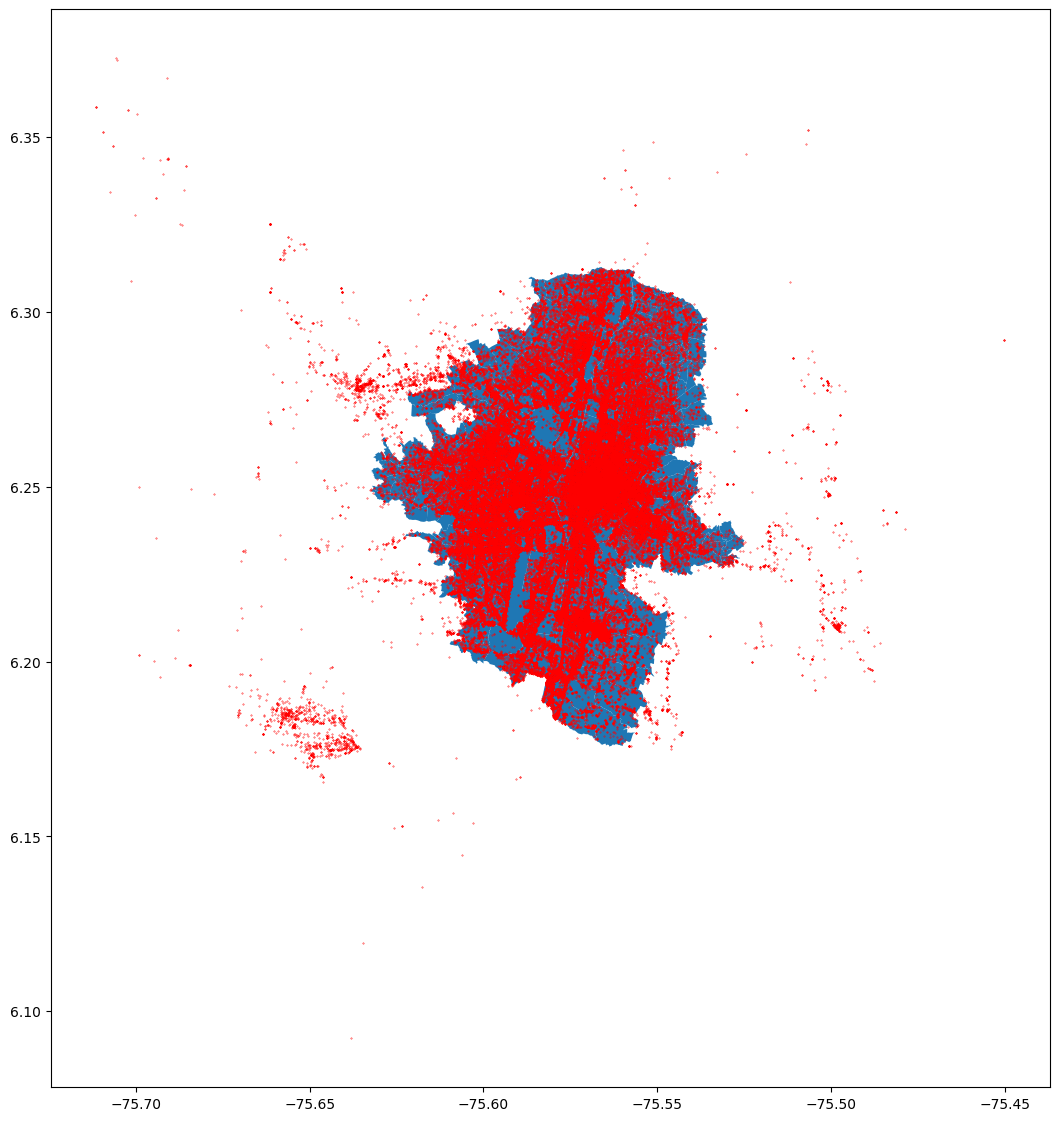

In [ ]:
axis = mede_shp.plot(figsize=(20,14))
hurtos_coord.plot(ax=axis, color = "red",markersize =0.1)

In [ ]:
med_hurtos = sjoin(hurtos_coord, mede_shp)

In [ ]:
med_hurtos.shape

(176631, 37)

In [ ]:
med_hurtos

,fecha_hecho,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,...,CODIGO,COMUNA,BARRIO,NOMBRE_BAR,SECTOR,INDICADOR_,NOMBRE_COM,SHAPE__Are,SHAPE__Len,key
0,2020-01-07 15:30:00-05:00,6.254597,-75.564769,Hombre,54,Divorciado(a),Caminata,Raponazo,Sin dato,No,...,1018,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18
3,2020-01-07 11:00:00-05:00,6.254530,-75.562335,Hombre,38,Casado(a),Automóvil,Rompimiento cerraduta,Sin dato,No,...,1018,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18
248,2019-01-03 20:00:00-05:00,6.251341,-75.561273,Mujer,20,Soltero(a),Caminata,Atraco,Sin dato,No,...,1018,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18
359,2019-01-04 20:40:00-05:00,6.255552,-75.564552,Hombre,38,Casado(a),Caminata,Atraco,Sin dato,Arma de fuego,...,1018,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18
498,2019-01-06 05:30:00-05:00,6.253717,-75.565744,Hombre,28,Soltero(a),Caminata,Escopolamina,Sin dato,Escopolamina,...,1018,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140652,2021-09-01 14:30:00-05:00,6.221423,-75.559726,Hombre,35,Soltero(a),Caminata,Engaño,No,No,...,0916,09,16,Asomadera No. 3,3,U,BUENOS AIRES,164904.652832,2467.417309,09_16
140653,2021-09-01 14:30:00-05:00,6.221423,-75.559726,Hombre,35,Soltero(a),Caminata,Engaño,No,No,...,0916,09,16,Asomadera No. 3,3,U,BUENOS AIRES,164904.652832,2467.417309,09_16
140654,2021-09-01 14:30:00-05:00,6.221423,-75.559726,Hombre,35,Soltero(a),Caminata,Engaño,No,No,...,0916,09,16,Asomadera No. 3,3,U,BUENOS AIRES,164904.652832,2467.417309,09_16
161342,2022-09-11 10:00:00-05:00,6.221049,-75.559594,Mujer,19,Soltero(a),Taxi,Atraco,Sin dato,Escopolamina,...,0916,09,16,Asomadera No. 3,3,U,BUENOS AIRES,164904.652832,2467.417309,09_16


De esta manera tenemos los casos al interior del límite geospacial de interés

<Axes: >

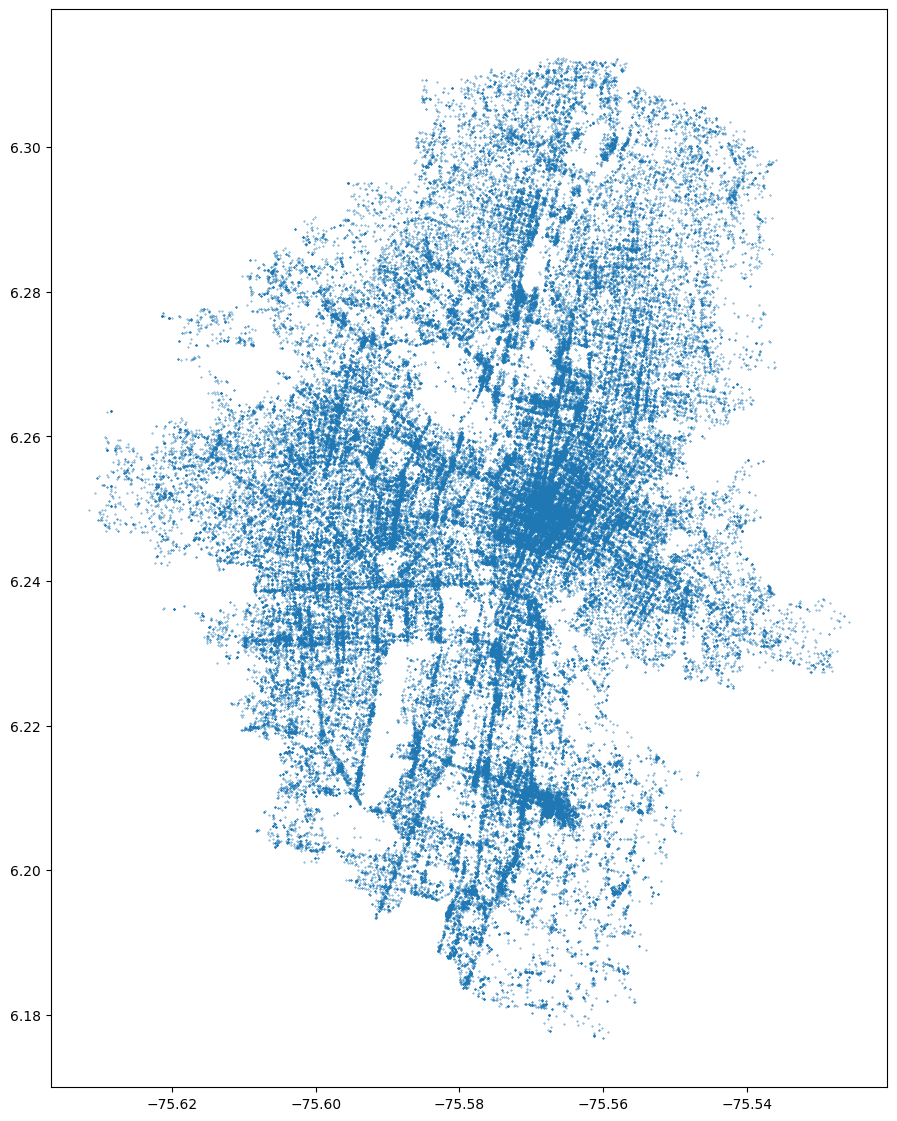

In [ ]:
med_hurtos.plot(markersize =0.1,figsize=(20,14))

Definimos un índice asociado con el anio y la semana de la ocurrencia del hecho, de esta manera podemos agrupar y encontrar el número de casos por semana entre el periodo 2018-2022


In [ ]:
#med_hurtos['anio_mes_semana'] = med_hurtos['anio'].astype(str)+'_' + med_hurtos['mes'].astype(str) +'_'+ med_hurtos['semana'].astype(str)
med_hurtos['anio_mes_semana'] = med_hurtos['anio'].astype(str)+'_' + med_hurtos['semana'].astype(str)

In [ ]:
med_hurtos.head()

,fecha_hecho,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,...,COMUNA,BARRIO,NOMBRE_BAR,SECTOR,INDICADOR_,NOMBRE_COM,SHAPE__Are,SHAPE__Len,key,anio_mes_semana
0,2020-01-07 15:30:00-05:00,6.254597,-75.564769,Hombre,54,Divorciado(a),Caminata,Raponazo,Sin dato,No,...,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18,2020_2
3,2020-01-07 11:00:00-05:00,6.254530,-75.562335,Hombre,38,Casado(a),Automóvil,Rompimiento cerraduta,Sin dato,No,...,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18,2020_2
248,2019-01-03 20:00:00-05:00,6.251341,-75.561273,Mujer,20,Soltero(a),Caminata,Atraco,Sin dato,No,...,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18,2019_1
359,2019-01-04 20:40:00-05:00,6.255552,-75.564552,Hombre,38,Casado(a),Caminata,Atraco,Sin dato,Arma de fuego,...,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18,2019_1
498,2019-01-06 05:30:00-05:00,6.253717,-75.565744,Hombre,28,Soltero(a),Caminata,Escopolamina,Sin dato,Escopolamina,...,10,18,Villa Nueva,3,U,LA CANDELARIA,315313.736816,2389.323012,10_18,2019_1


In [ ]:
med_hurtos.sort_values(by=['anio','mes'],inplace=True)

In [ ]:
med_hurtos.anio_mes_semana.value_counts()

2019_32    1477
2019_51    1283
2020_2     1252
2019_46    1174
2019_31    1121
           ... 
2020_15     125
2020_14     107
2020_13      95
2021_53      84
2022_52      72
Name: anio_mes_semana, Length: 259, dtype: int64

Una vez tenemos el índice, agrupamos por semana y llevamos estos datos a una forma tabular

In [ ]:
df3 = pd.pivot_table(med_hurtos, values=['fecha_hecho'],index=['key'],
                    columns=['anio_mes_semana'], aggfunc='count')

In [ ]:
df3.columns = df3.columns.droplevel(0) #remove amount
df3.columns.name = None               #remove categories
df3 = df3.reset_index()                #index to columns

In [ ]:
df3

,key,2018_1,2018_10,2018_11,2018_12,2018_13,2018_14,2018_15,2018_16,2018_17,...,2022_45,2022_46,2022_47,2022_48,2022_5,2022_52,2022_6,2022_7,2022_8,2022_9
0,01_01,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,...,1.0,4.0,4.0,NaN,1.0,1.0,3.0,2.0,NaN,1.0
1,01_02,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,2.0,NaN,2.0,1.0,NaN,1.0
2,01_03,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,...,1.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN
3,01_04,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,...,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01_05,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,16_17,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,NaN,NaN
261,16_18,NaN,1.0,NaN,1.0,1.0,3.0,3.0,3.0,NaN,...,2.0,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,4.0
262,16_19,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,3.0,...,NaN,4.0,1.0,NaN,3.0,NaN,7.0,NaN,NaN,1.0
263,16_20,2.0,4.0,NaN,1.0,NaN,2.0,NaN,NaN,1.0,...,NaN,2.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0


Hacemos un llenado de valore a cero y posteriormente guardamos.

In [ ]:
df3.fillna(0, inplace=True)

In [ ]:
#df3.to_csv('/content/drive/MyDrive/Maestria_eafit/conteo_hurtos/casos_anio_semana_cols.csv')

A continuación creamos una estrucutra similar para el conteo por años

In [ ]:
df_anio = pd.pivot_table(med_hurtos, values=['fecha_hecho'],index=['key'],
                    columns=['anio','semana'], aggfunc='count', fill_value=0)

In [ ]:
df_anio

fecha_hecho                               ...                         \
anio          2018                               ... 2022                     
semana          1  2  3  4  5   6   7  8  9  10  ...   40 41 42 43 44 45 46   
key                                              ...                          
01_01            1  0  1  0  0   0   1  0  0  0  ...    1  0  3  1  2  1  4   
01_02            0  0  0  0  0   0   0  0  0  1  ...    0  0  1  0  0  0  2   
01_03            0  0  0  1  0   0   0  0  1  0  ...    1  1  1  0  1  1  3   
01_04            0  0  1  0  0   1   0  0  2  0  ...    1  1  2  1  0  2  1   
01_05            0  0  0  1  0   1   0  0  0  0  ...    1  0  1  2  0  0  1   
...            ... .. .. .. ..  ..  .. .. .. ..  ...  ... .. .. .. .. .. ..   
16_17            0  0  0  0  1   0   0  0  0  0  ...    0  2  0  2  2  0  0   
16_18            0  8  0  0  4  10  10  2  1  1  ...    4  5  1  1  1  2  0   
16_19            0  1  0  2  0   3   0  4  0  0  ...    0  1  1  0  2  0  4   
16_20            2  4  0  0  2   4   0  3  0  4  ...    0  2  0  7  1  0  2   
16_21            4  1  5  0  1   2   0  9  1  2  ...    3  2  2  0  4  2  4   

                 
anio             
semana 47 48 52  
key              
01_01   4  0  1  
01_02   0  0  0  
01_03   0  0  0  
01_04   2  0  0  
01_05   0  0  0  
...    .. .. ..  
16_17   0  0  0  
16_18   0  1  0  
16_19   1  0  0  
16_20   1  0  0  
16_21   5  1  0  

[265 rows x 259 columns]

In [ ]:
df4 = df_anio.stack(['semana','anio'])

In [ ]:
df4 = df4.reset_index()

In [ ]:
df4

,key,semana,anio,casos
0,01_01,1,2018,1.0
1,01_01,1,2019,2.0
2,01_01,1,2020,2.0
3,01_01,1,2021,0.0
4,01_01,1,2022,1.0
...,...,...,...,...
68630,16_21,52,2020,0.0
68631,16_21,52,2021,0.0
68632,16_21,52,2022,0.0
68633,16_21,53,2020,1.0


In [ ]:
df4.columns = ['key', 'semana', 'anio', 'casos']

In [ ]:
df4 = pd.get_dummies(df4, columns = ['anio'])

In [ ]:
df4.casos = df4.casos.astype('int64')

In [ ]:
df4

,key,semana,casos,anio_2018,anio_2019,anio_2020,anio_2021,anio_2022
0,01_01,1,1,1,0,0,0,0
1,01_01,1,2,0,1,0,0,0
2,01_01,1,2,0,0,1,0,0
3,01_01,1,0,0,0,0,1,0
4,01_01,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
68630,16_21,52,0,0,0,1,0,0
68631,16_21,52,0,0,0,0,1,0
68632,16_21,52,0,0,0,0,0,1
68633,16_21,53,1,0,0,1,0,0


In [ ]:
#df4.to_csv('/content/drive/MyDrive/Maestria_eafit/conteo_hurtos/casos_anio_semana2.csv')

Ahora por mes

In [ ]:
 df5 = pd.pivot_table(med_hurtos, values=['fecha_hecho'],index=['key'],
                    columns=['mes'], aggfunc='count')

In [ ]:
df5.columns = df5.columns.droplevel(0) #remove amount
df5.columns.name = None               #remove categories
df5 = df5.reset_index()                #index to columns

In [ ]:
df5

,key,1,2,3,4,5,6,7,8,9,10,11,12
0,01_01,31.0,26.0,37.0,28.0,33.0,26.0,25.0,32.0,26.0,38.0,34.0,24.0
1,01_02,8.0,8.0,14.0,2.0,4.0,3.0,9.0,11.0,8.0,8.0,9.0,5.0
2,01_03,26.0,14.0,33.0,12.0,25.0,27.0,22.0,26.0,19.0,32.0,24.0,34.0
3,01_04,6.0,5.0,12.0,13.0,15.0,12.0,3.0,7.0,25.0,11.0,18.0,21.0
4,01_05,17.0,12.0,6.0,13.0,22.0,18.0,8.0,8.0,6.0,10.0,16.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,16_17,23.0,15.0,8.0,16.0,18.0,28.0,16.0,9.0,15.0,27.0,10.0,25.0
261,16_18,56.0,69.0,28.0,44.0,80.0,44.0,41.0,41.0,31.0,40.0,22.0,32.0
262,16_19,30.0,21.0,20.0,23.0,25.0,11.0,25.0,46.0,25.0,19.0,51.0,13.0
263,16_20,53.0,33.0,25.0,36.0,74.0,39.0,41.0,55.0,88.0,20.0,48.0,26.0


In [ ]:
#df5.to_csv('/content/drive/MyDrive/Maestria_eafit/conteo_años/casos_por_mes.csv')

In [20]:
#med_hurtos.to_csv('/content/drive/MyDrive/Maestria_eafit/conteo_hurtos/sabana_hurtos.csv')

In [ ]:
def df_last_transaction(self):
        execute_br = report["query"].replace('$TYPE','BR')
        
        execute_er = report["query"].replace('$TYPE','ER')
        df_from_athena_er = wr.athena.read_sql_query(execute_er, database=source_db,ctas_approach=False,s3_output= 's3://pco-datalake-prod-us-east-1-097531158994-analytics/athena-datascientist/automation_process/athena_python_temp_files/temp_files/')
        df_from_athena_er.rename(columns={'trn_acc_id': 'acc_id', 'max_fecha': 'ultima_transaccion_redencion'}, inplace=True)
        df_ultima_transaccion = pd.merge(df_from_athena_br,df_from_athena_er,on='acc_id')
        return df_ultima_transaccion

In [ ]:
#Reducir a una linea
self._dynamo_access.set_table(self.params.get_param('table_name')) # get item y reducir con la 56. apoyado en el main.
report = self._dynamo_access.get_item("name_report", self.params.get_param('table_last_transaction'))

In [ ]:
source_db = "pco_datalake_prod_datalake_odsclm_db"
path_s3 = 's3://pco-datalake-prod-us-east-1-097531158994-analytics/athena-datascientist/automation_process/athena_python_temp_files/temp_files/'

execute_br = report["query"].replace('$TYPE',variables['redencion']['tipo'])
df_from_athena_br = wr.athena.read_sql_query(execute_br, database=source_db,ctas_approach=False,
                                        s3_output=path_s3 )
df_from_athena_br.rename(columns={'trn_acc_id': 'acc_id', 'max_fecha': variables['redencion']['max_fecha']}, inplace=True)
df_ultima_transaccion = pd.merge(df_from_athena_br,df_from_athena_er,on='acc_id')


In [3]:
import pandas as pd

In [ ]:
variables = {'redencion': {'tipo':'BR', 'max_fecha':'ultima_transaccion_acumulacion'},'acumulacion': 'ER'}

In [4]:
def read_df_athena(source: str, path_s3: str, query_result: dict ,transaction_type: dict = None) -> pd.DataFrame:
    """
    ¿Qué hace? (Única responsabilidad)
    Parámetros
    ¿Qué regresa?
    """
    execute_br = query_result["query"].replace('$TYPE',transaction_type['tipo'])
    df_from_athena = wr.athena.read_sql_query(execute_br, database=source_db,ctas_approach=False,
                                        s3_output=path_s3 )
    df_from_athena.rename(columns={'trn_acc_id': 'acc_id', 'max_fecha': transaction_type['max_fecha']}, inplace=True)
    return df_from_athena

In [ ]:
df_athena = pd.merge(read_df_athena(source_db, variables['redencion']),
                    read_df_athena(source_db,variables['acumulacion'] ),
                    on='acc_id')

In [ ]:

for transaction in ['redencion', 'acumulacion']:
    df_athena = read_df_athena(source_db, )

In [ ]:
def read_df_athena(source: str, path_s3: str, query_result: dict ,transaction_type: dict = None) -> pd.DataFrame:
    """
    ¿Qué hace? (Única responsabilidad)
    Parámetros
    ¿Qué regresa?
    """
    if transaction_type:
        execute_br = query_result["query"]['S'].replace('$TYPE',transaction_type['tipo'])
        df_from_athena = wr.athena.read_sql_query(execute_br, database=source,ctas_approach=False,
                                        s3_output=path_s3 )
        df_from_athena.rename(columns={'trn_acc_id': 'acc_id', 'max_fecha': transaction_type['max_fecha']}, inplace=True)
    else:
        df_from_athena = wr.athena.read_sql_query(query_result["query"]['S'], database=source,ctas_approach=False,
                                        s3_output=path_s3 )
    return df_from_athena

In [7]:
transaction_type = None
transaction_type = 'B'

In [9]:
if transaction_type:
    print('hay')
else:
    print('No hay')

hay
